<a id='sec_Notebooks_Circ_1_qubit'></a>
# Mediciones en circuitos de un qubit
$\newcommand{\ket}[1]{|#1\rangle}$

In [1]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

NOT in colab


In [2]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

In [3]:
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex  

In [4]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    d_latex = psi.draw('latex', prefix=prefix)
    display(d_latex)
    #
    d_bloch = psi.draw('bloch')
    if isinstance(inches, (int,float)):
        if inches > 0:
            d_bloch.set_size_inches(inches, inches, forward=True)
            display(d_bloch)
    else:
        display(d_bloch)

# Función para simular un cirucito dado:
# devuelve esta terna (estado final, cuenta, resultado del job)
def my_get_circuit_state(qcirc_in, shots=1, final_probe=True):
    # Instancia del simulador
    sim = AerSimulator(method = "statevector")
    
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_statevector()
    
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, sim)
    result = sim.run(qobj, shots=shots).result()
    state = result.get_statevector()
    counts_ideal = result.get_counts()
    
    return state, counts_ideal, result

# Función para simular un cirucito dado devuelve el resultado
# de la simulación
def my_circuit_simulation(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "statevector")
     
    # Hacemos una simulación y obtenemos los resultados


    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result

<a id='sec_Notebooks_Circ_1_qubit_1'></a>
## Creación y medición de circuitos de 1 qúbit con Qiskit

Vamos a introducir los objetos Qiskit **Registros**, que pueden ser cuánticos o clásicos.

Básicamente un registro es una _array_ de qubits o bits, respectivamente, y nos sirven para agrupar lógicamente grupos de bits ya sean cuánticos (qubits) o clásicos. 

In [5]:
# Definimos un registro cuántico con un qubit, etiquetado con 'q'
quantum_reg = QuantumRegister(1, 'q') 

# Definimos un registro clásico con un bit, etiquetado con 'c'
classic_reg = ClassicalRegister(1, 'c')

<a id='sec_Notebooks_Circ_1_qubit_1.1'></a>
### Circuito con solo medidor

Creamos un primer circuito. En este solo vamos a poner un medidor. De esta forma vamos a verificar que por defecto Qiskit (y la mayoría de libreas de quantum) inicializan los estados en $| 0 \rangle$

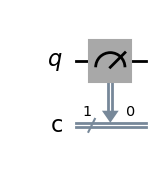

In [6]:
# Creamos el circuito a partir de los registros
circuit = QuantumCircuit(quantum_reg, classic_reg)

# Añadimos el medidor
#   - El primer argumento son los qubits a medir
#   - El segundo argumento son los bits donde volcar el resultado de la medición
circuit.measure(quantum_reg, classic_reg)

# Dibujamos el circuito
circuit.draw(output='mpl', style="iqp") # tipo de figura matplotlib (mpl)

Vamos a simular

In [7]:
# Generamos una instancia del simulador;
# con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

# Transpilamos
circuit_t = transpile(circuit, backend = simulador)

# Ejecutamos la simulación, con un buen número de repeticiones
# (shots = 1000), ya que tenemos un medidor
job = simulador.run(circuit_t, shots = 1000)
result = job.result()

Imprimamos el objeto resultado de la simulación

In [8]:
display(result)

Result(backend_name='aer_simulator_statevector', backend_version='0.14.2', qobj_id='', job_id='6544734e-5a19-4ebb-b361-b0e87df5106e', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 1000}), header=QobjExperimentHeader(creg_sizes=[['c', 1]], global_phase=0.0, memory_slots=1, n_qubits=1, name='circuit-158', qreg_sizes=[['q', 1]], metadata={}), status=DONE, seed_simulator=3032540666, metadata={'time_taken': 0.000827818, 'num_bind_params': 1, 'parallel_state_update': 20, 'parallel_shots': 1, 'required_memory_mb': 1, 'input_qubit_map': [[0, 0]], 'method': 'statevector', 'device': 'CPU', 'num_qubits': 1, 'sample_measure_time': 0.000542567, 'active_input_qubits': [0], 'num_clbits': 1, 'remapped_qubits': False, 'runtime_parameter_bind': False, 'max_memory_mb': 64000, 'noise': 'ideal', 'measure_sampling': True, 'batched_shots_optimization': False, 'fusion': {'applied': False, 'max_fused_qubits': 5, 'threshold': 14, 'enable

Vemos que la salida tiene mucha información. 
Lo más importante es saber cuantas veces se ha medido cada posible medida de nuestro medidor.

In [9]:
counts = result.get_counts()
counts

{'0': 1000}

Vemos que, como era de esperar, las 1000 ejecuciones del circuito nos han dado $| 0 \rangle$

Podemos hacer un histograma con las cuentas. 

Nuevamente, el histograma es una figura de Matplotlib, así que podríamos usar `savefig()`

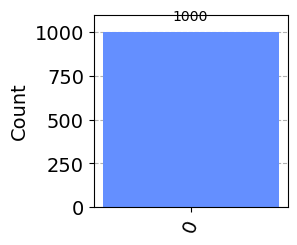

In [10]:
fig = plot_histogram(counts, figsize=(2.5,2.5))
#Fig.savefig('/tmp/Fig_circuit_1_hist')
display(fig)

<a id='sec_Notebooks_Circ_1_qubit_1.2'></a>
### Circuito de un qubit con puertas y medidor

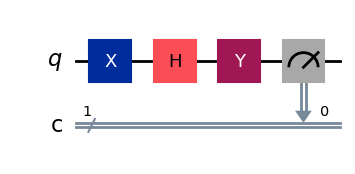

In [11]:
# Creamos el circuito pasandole los registros. 
circuit = QuantumCircuit(quantum_reg, classic_reg)

# Añadimos una puerta X seguida de una H al primer (y único) qúbit
circuit.x(0)
circuit.h(0)
circuit.y(0)

# Añadimos el medidor
circuit.measure(quantum_reg, classic_reg)

# Dibujemos el circuito
display(circuit.draw(output='mpl', style="iqp")) 


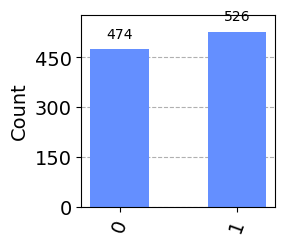

In [12]:
# Usemos nuestra función de utilería que simula y nos da el resultado
result = my_circuit_simulation(circuit, 1000)

# Visualicemos el estado y las probabilidades
counts = result.get_counts()
display(plot_histogram(counts, figsize=(2.5,2.5)))

In [13]:
# Vamos a definir una función para calcular la distribución de probabilidad

# Toma un histograma en formato diccionario tal como lo devuelve get_counts()
# y lo transforma en otro diccionario con las frecuencias relativas (distribución
# de probabilidad)
def my_get_prob_dist(counts, nd=3):
    N = 0
    for i in counts.items():
        N += i[1]
    prob = {}
    for i in counts.items():
        prob[i[0]] = np.round(i[1]/N, nd)
    return prob
    

prob_dist = my_get_prob_dist(counts)
print("probability distribution =", prob_dist)

probability distribution = {'0': 0.474, '1': 0.526}


<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
Con lápiz y papel, en este circuito, ¿cuál es el estado final del qubit antes del medidor?
    
Observa las frecuencias de aparición de las medidas ¿son aproximadamente las que deben salir?
<hr>
</div>

<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
Añade un medidor al circuito del primer ejercicio del cuadernillo anterior, que no era más que una mera inicialización del qubit.

Comprueba que el histograma está acorde al cuadrado de las amplitudes 0 y 1 en el vector de ini
<hr>
</div>

<a id='sec_Notebooks_Circ_1_qubit_3'></a>
## La moneda cuántica   

Vamos a ver aquí a modo de ejemplo un experimento simple: **la moneda cuántica**.

El resultado de tirar una moneda al aire es una variable aleatoria con dos resultados equiprobables:  cara y cruz.  Es irrelevante si analizamos el resultado cada tirada o cada dos, o tres tiradas. Las frecuencias relativas de caras y cruces, siempre serán próximas a $1/2$. Es decir, podemos tirar la moneda, recogerla sin mirarla, volver a tirar, y las probabilidades no cambian.

Podemos imaginar un experimento similar con un qúbit, donde cara $\to 0$ y cruz $\to 1$ son los resultados posibles de la medida en la base $Z$. Como al tirar la moneda, mientras esta está en el aire podemos pensar que está en ``una superposición equiprobable del cara y cruz'', el hecho de **tirar la moneda** en computación cuántica será aplicar el operador $H$. 

Haciendo esta consideración, podemos ver que no es lo mismo tirar la moneda 1 vez y mirar 

$$
\ket{0}~ \stackrel{\rm tirar}{\longrightarrow} ~ H \ket{0}= \ket{+} ~ \stackrel{\rm medir}{\longrightarrow} ~p(0) = p(1) = 0.5
$$

que tirarla dos veces y mirar

$$
\ket{0}~ \stackrel{\rm tirar}{\longrightarrow} ~ H \ket{0}~ \stackrel{\rm tirar}{\longrightarrow} H^2\ket{0} = \ket{0} ~ \stackrel{\rm medir}{\longrightarrow} ~p(0) = 1 ~,~p(1) = 0
$$

El objetivo de este experimento es simplemente ver que ciertas puertas son sus propias inversas y que cuando aplicamos las aplicamos un número par de veces seguidas, es como si no aplicáramos nada. 

Hagamos dos circuitos para hacer dos pruebas. Veamos que pasa si medimos después de la primero $H$ y si no:

In [27]:
classic_reg_2_bits = ClassicalRegister(2)

circuit_coin_1 = QuantumCircuit(quantum_reg, classic_reg_2_bits)
circuit_coin_1.h(0)
circuit_coin_1.measure(quantum_reg, classic_reg_2_bits[0]) # Añadimos una medida intermedia.
circuit_coin_1.h(0)
circuit_coin_1.measure(quantum_reg, classic_reg_2_bits[1])

circuit_coin_2 = QuantumCircuit(quantum_reg, classic_reg)
circuit_coin_2.h(0)
circuit_coin_2.h(0)
circuit_coin_2.measure(quantum_reg, classic_reg)

#display(circuit_coin_1.draw(), circuit_coin_2.draw())

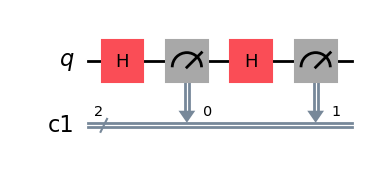

In [28]:
fig_coin_1 = circuit_coin_1.draw(output='mpl', style="iqp") # mpl es de Matplolib
display(fig_coin_1)

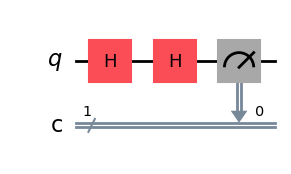

In [29]:
fig_coin_2 = circuit_coin_2.draw(output='mpl', style="iqp") # mpl es de Matplolib
display(fig_coin_2)

In [17]:
# transpilamos

result_coin_1 = my_circuit_simulation(circuit_coin_1, 1000)
result_coin_2 = my_circuit_simulation(circuit_coin_2, 1000)

# Conteo de medidas
counts_coin_1 = result_coin_1.get_counts()
print("Resultado (circuito 1): ", counts_coin_1)
counts_coin_2 = result_coin_2.get_counts()
print("Resultado (circuito 2): ", counts_coin_2)

Resultado (circuito 1):  {'11': 265, '00': 259, '10': 232, '01': 244}
Resultado (circuito 2):  {'0': 1000}


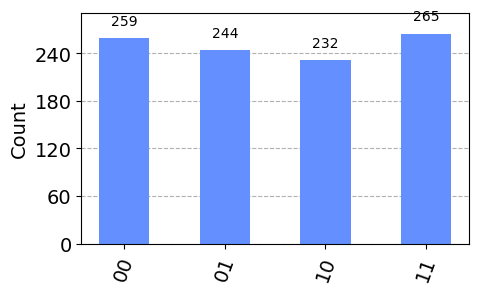

In [18]:
display(plot_histogram(counts_coin_1, figsize=(5,3)))

Lo resultados $00$ y$11$ son aquellos en los que hemos medido los mismo en los dos medidores, es decir, en los dos tiradas ha salido cara o cruz. 
En los otros casos, no hemos medido lo mismo, es decir, en una tirada ha salido cara y en la otra cruz.

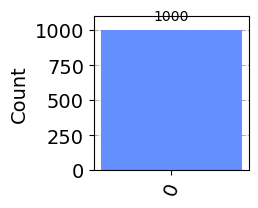

In [19]:
display(plot_histogram(counts_coin_2, figsize=(2,2)))

Vemos que **medir altera nuestro resultado**

<a id='sec_Notebooks_Circ_1_qubit_4'></a>
## Valores esperados  

<a id='sec_Notebooks_Circ_1_qubit_4.1'></a>
### Valor esperado de un observable arbitrario (operador hermítico).

Vamos a ver como se mide el valor esperado de un observable arbitrario $A$ en un estado arbitrario $\ket{\Psi}$. Estos valores esperados se denotan de la siguiente forma: $\langle Z \rangle_\Psi$. 

Cualquier observable sobre un cúbit cumple $A = A^\dagger$ (es hermítico) con lo que puede expresarse en la base
	\begin{equation} \label{ec_medidas1_expansion_A_en_Paulis}
	A = a I + n_x X + n_y Y  + n_z Z \, .
	\end{equation}
Los coeficientes se obtienen haciendo uso de las relaciones $\frac{1}{2}$ tr$ (\sigma_i \sigma_j) = \delta_{ij}$ y de tr$(\sigma_i)=0$, de las cuales se obtiene
	$$\begin{align}
	&\boxed{a  = \frac{1}{2} \text{ tr}(A)},        &         &\boxed{n_i = \frac{1}{2} \text{ tr}  (A \sigma_i)},
	\end{align} 
    $$
Entonces, podremos obtener el valor esperado de $A$  si somos capaces de medir los valores esperados de $X,$ $Y$ y $Z$.
	\begin{equation}
	\boxed{\langle A\rangle_\Psi = a + n_x \langle X\rangle_\Psi + n_y \langle Y\rangle_\Psi + n_z \langle Z\rangle_\Psi}
	\end{equation}

<a id='sec_Notebooks_Circ_1_qubit_4.1.1'></a>
#### Inicializando estado $| \Psi \rangle $

In [20]:
# Vamos a definir un circuito con un valor inicial arbitario
# y vamos a simularlo calculando su distribución de probabilidad

# Inicializamos un estado arbitrario en la esfera de Bloch
theta = 0.5  #rad
phi   = 0.3  #rad
psi_state = [np.cos(theta/2),(np.exp(1j*phi))*np.sin(theta/2)]

# Veamos el vector de estado
Psi = Statevector(psi_state)
display(Psi.draw('latex'))

qc = QuantumCircuit(quantum_reg, classic_reg)
qc.initialize(Psi)
qc.measure(quantum_reg, classic_reg)
display(qc.draw('text',style="iqp"))
r = my_circuit_simulation(qc, 1000)
counts_state = r.get_counts()
prob_distr_state = my_get_prob_dist(counts_state)


<IPython.core.display.Latex object>

┌───────────────────────────────────────┐┌─┐
  q: ┤ Initialize(0.96891,0.23635+0.073113j) ├┤M├
     └───────────────────────────────────────┘└╥┘
c: 1/══════════════════════════════════════════╩═
                                               0

In [21]:
print('p_0=', np.round(np.abs(psi_state[0])**2,3),', p_1=', np.round(np.abs(psi_state[1])**2,3))
print("probability distribution =", prob_distr_state)

p_0= 0.939 , p_1= 0.061
probability distribution = {'1': 0.048, '0': 0.952}


<a id='sec_Notebooks_Circ_1_qubit_4.1.2'></a>
#### Midiendo $\langle Z \rangle$

In [22]:
# Circuito
circuit_Z_mean = QuantumCircuit(quantum_reg, classic_reg)
circuit_Z_mean.initialize(Psi,0)
circuit_Z_mean.measure(quantum_reg, classic_reg)

display(circuit_Z_mean.draw())

# Ejecutamos
result_Z_mean = my_circuit_simulation(circuit_Z_mean, 1000)
counts_Z_mean = result_Z_mean.get_counts()
print("Resultado: ", counts_Z_mean)

# Distribución de probabilidad
prob_distr_Z_mean = my_get_prob_dist(counts_Z_mean)
print("probability distribution =", prob_distr_Z_mean)

# Calculamos <Z>
mean_Z = 0

for bits, probs  in prob_distr_Z_mean.items():
    mean_Z += (-1)**(int(bits)) * probs  

print('<Z> =',np.round(mean_Z,5))

┌───────────────────────────────────────┐┌─┐
  q: ┤ Initialize(0.96891,0.23635+0.073113j) ├┤M├
     └───────────────────────────────────────┘└╥┘
c: 1/══════════════════════════════════════════╩═
                                               0

Resultado:  {'1': 50, '0': 950}
probability distribution = {'1': 0.05, '0': 0.95}
<Z> = 0.9


<a id='sec_Notebooks_Circ_1_qubit_4.1.3'></a>
#### Midiendo $\langle X \rangle$

In [23]:
# Circuito
circuit_X_mean = QuantumCircuit(quantum_reg, classic_reg)
circuit_X_mean.initialize(Psi,0)
circuit_X_mean.h(quantum_reg)
circuit_X_mean.measure(quantum_reg, classic_reg)

display(circuit_X_mean.draw())

# Ejecutamos
result_X_mean = my_circuit_simulation(circuit_X_mean, 1000)
counts_X_mean = result_X_mean.get_counts()
print("Resultado: ", counts_X_mean)

# Distribución de probabilidad
prob_distr_X_mean = my_get_prob_dist(counts_X_mean)
print("probability distribution =", prob_distr_X_mean)

# Calculamos <X>
mean_X = 0

for bits, probs  in prob_distr_X_mean.items():
    mean_X += (-1)**(int(bits)) * probs  

print('<X> =',np.round(mean_X,5))

┌───────────────────────────────────────┐┌───┐┌─┐
  q: ┤ Initialize(0.96891,0.23635+0.073113j) ├┤ H ├┤M├
     └───────────────────────────────────────┘└───┘└╥┘
c: 1/═══════════════════════════════════════════════╩═
                                                    0

Resultado:  {'1': 252, '0': 748}
probability distribution = {'1': 0.252, '0': 0.748}
<X> = 0.496


<a id='sec_Notebooks_Circ_1_qubit_4.1.4'></a>
#### Midiendo $\langle Y \rangle$

In [24]:
# Circuito
circuit_Y_mean = QuantumCircuit(quantum_reg, classic_reg)
circuit_Y_mean.initialize(Psi,0)
circuit_Y_mean.sdg(quantum_reg)
circuit_Y_mean.h(quantum_reg)
circuit_Y_mean.measure(quantum_reg, classic_reg)

display(circuit_Y_mean.draw())

# Ejecutamos
result_Y_mean = my_circuit_simulation(circuit_Y_mean, 1000)
counts_Y_mean = result_Y_mean.get_counts()
print("Resultado: ", counts_Y_mean)

# Distribución de probabilidad
prob_distr_Y_mean = my_get_prob_dist(counts_Y_mean)
print("probability distribution =", prob_distr_Y_mean)

# Calculamos <Y>
mean_Y = 0

for bits, probs  in prob_distr_Y_mean.items():
    mean_Y += (-1)**(int(bits)) * probs  

print('<Y> =',np.round(mean_Y,5))

┌───────────────────────────────────────┐┌─────┐┌───┐┌─┐
  q: ┤ Initialize(0.96891,0.23635+0.073113j) ├┤ Sdg ├┤ H ├┤M├
     └───────────────────────────────────────┘└─────┘└───┘└╥┘
c: 1/══════════════════════════════════════════════════════╩═
                                                           0

Resultado:  {'1': 388, '0': 612}
probability distribution = {'1': 0.388, '0': 0.612}
<Y> = 0.224


<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>

Toma los valores medios medidos anteriores $x=\langle X \rangle$, $y=\langle Y \rangle$, $z=\langle Z \rangle$ y a partir de ellos:
- Construye el vector cartesiano $\vec{n}=(x,y,z)$
- Normalízalo: $\hat{n}$
- Dibúja estas coordenadas de $\hat{n}$ sobre la esfera de Bloch (sugerencia: consulta la conversión de coordenadas cartesianas a esféricas: https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates ; puedes dibujar un estado con las coordenadas esféricas resultantes)

¿Qué observas? Explica el resultado
<hr>
</div>

<a id='sec_Notebooks_Circ_1_qubit_4.2'></a>
### Valor esperado de un operador unitario (no necesariamente hermítico)

Vamos a construir dos operadores U y V y calcular 
$$\langle V \rangle_\Psi = \langle \Psi | V| \Psi \rangle = \langle 0 | U^\dagger V U |0\rangle = \langle 0 | {\tilde \Psi} \rangle
$$

In [25]:
from qiskit.circuit.library import U3Gate

circuit_V_mean = QuantumCircuit(quantum_reg, classic_reg)

theta_U  = np.pi/6
phi_U    = np.pi/2
varphi_U = np.pi
U        = U3Gate(theta_U, phi_U, varphi_U)
U_dagger = U3Gate(theta_U, phi_U, varphi_U).inverse()

theta_V  = np.pi/2
phi_V    = np.pi/3
varphi_V = 2*np.pi/7
V        = U3Gate(theta_V, phi_V, varphi_V)

circuit_V_mean.append(U, quantum_reg)
circuit_V_mean.append(V, quantum_reg)
circuit_V_mean.append(U_dagger, quantum_reg)
circuit_V_mean.measure(quantum_reg, classic_reg)

display(circuit_V_mean.draw())

# Transpilamos
t_circuit_V_mean = transpile(circuit_V_mean, backend = simulador)

display(t_circuit_V_mean.draw())

# Ejecutamos
shots = 50000
result_V_mean = simulador.run(t_circuit_V_mean, shots = shots).result()
counts_V_mean = result_V_mean.get_counts()
print("Resultado: ", counts_V_mean)

# Media
V_mean = np.sqrt(counts_V_mean['0']/shots)
print(" |<V>| = ", V_mean, ",  ||<V>||^2 = ", np.abs(V_mean) ** 2)

┌───────────────┐┌──────────────────┐┌──────────────────┐┌─┐
  q: ┤ U3(π/6,π/2,π) ├┤ U3(π/2,π/3,2π/7) ├┤ U3(-π/6,-π,-π/2) ├┤M├
     └───────────────┘└──────────────────┘└──────────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════╩═
                                                               0

global phase: 6.1192
     ┌────────────────────────────┐┌─┐
  q: ┤ U3(0.65757,2.8716,-0.5988) ├┤M├
     └────────────────────────────┘└╥┘
c: 1/═══════════════════════════════╩═
                                    0

Resultado:  {'1': 5182, '0': 44818}
 |<V>| =  0.9467629059062254 ,  ||<V>||^2 =  0.8963600000000002


<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>

<!--
<b> <font size="+1"><span style="color:red">[OPCIONAL, PARA OPTAR A NOTA] </span></font></b>
-->

Con el método Qiskit ```.to_matrix()``` de los operadores, como, U y V, se puede obtener la representación matricial de los mismos.

A partir de dicha representación, determina numéricamente las siguientes espressiones, que son equivalentes a la medición anterior (nótese que $|\Psi\rangle = U |0\rangle$ y $| \tilde{\Psi}\rangle = U^{\dagger} V U |0\rangle$):

- $||\langle \Psi | V| \Psi\rangle ||^2$
- $||\langle 0 | U^{\dagger} V U | 0 \rangle ||^2$
- $||\langle 0|\tilde{\Psi} \rangle||^2$

Observando los valores de las expresiones $\langle \Psi | V| \Psi \rangle$, $\langle 0|\tilde{\Psi} \rangle$:
- ¿pueden tener un _valor complejo_ en este caso?

<hr>
</div>

In [26]:
import qiskit
from qiskit_aer import AerSimulator
import qiskit.tools.jupyter
%qiskit_version_table